**Partie 1: Téléchargement des stocks**

In [ ]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

# pip install numpy
# conda install -c anaconda pandas
# conda install -c conda-forge matplotlib

import datetime as dt # For defining dates

import time

# In Powershell Prompt : conda install -c conda-forge multitasking
# pip install -i https://pypi.anaconda.org/ranaroussi/simple yfinance

import yfinance as yf

# To show all your output File -> Preferences -> Settings Search for Notebook
# Notebook Output Text Line Limit and set to 100

# Used for file handling like deleting files
import os
# conda install -c conda-forge cufflinks-py
# conda install -c plotly plotly
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()

from plotly.subplots import make_subplots

# New Imports
# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

import warnings
warnings.simplefilter("ignore")

Constant


In [ ]:
PATH = "D:/Python for Finance/Wilshire_Stocks/"

# Start end date defaults
S_DATE = "2017-02-01"
E_DATE = "2022-12-06"
S_DATE_DT = pd.to_datetime(S_DATE)
E_DATE_DT = pd.to_datetime(E_DATE)

Get Column Data from CSV


In [ ]:
def get_column_from_csv(file, col_name):
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(file)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df[col_name]

Get Stock Tickers


In [ ]:
tickers = get_column_from_csv("D:/Python for Finance/Wilshire-5000-Stocks.csv", "Ticker")
print(len(tickers))

Save Stock Data to CSV


In [ ]:
# Function that gets a dataframe by providing a ticker and starting date
#folder où on veut sauvgarder nos csv files
def save_to_csv_from_yahoo(folder, ticker):
    stock = yf.Ticker(ticker)
    
    try:
        print("Get Data for : ", ticker)
        # Get historical closing price data
        df = stock.history(period="5y")
    
        # Wait 2 seconds
        time.sleep(2)
        
        # Remove the period for saving the file name
        # Save data to a CSV file
        # File to save to 
        the_file = folder + ticker.replace(".", "_") + '.csv'
        print(the_file, " Saved")
        df.to_csv(the_file)
    except Exception as ex:
        print("Couldn't Get Data for :", ticker)

Download All Stocks


In [ ]:
for x in range(0, 3481):
    save_to_csv_from_yahoo(PATH, tickers[x])
    print("Finished")

**Partie 2: Calc Stats**

In [ ]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_stock_df_from_csv(ticker):
    
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col=0)# on utilise la date( la premiere colonne  ) comme index pour la data frame.
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df

Get all Stocks Downloaded in List


In [ ]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers
# tickers.remove('.ds_Store') MacOS Only
tickers.sort()
len(tickers)

Add Daily Returns

ajouter une colonne qui calcule le changement de prix pour chaque jours et pour chaque tickers. 


In [ ]:
# Shift provides the value from the previous day
# NaN is displayed because there was no previous day price for the 1st calculation
def add_daily_return_to_df(df):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    # df.to_csv(PATH + ticker + '.csv')
    return df 

Add Cumulative Returns


In [ ]:
def add_cum_return_to_df(df):
    df['cum_return'] = (1 + df['daily_return']).cumprod()
    # df.to_csv(PATH + ticker + '.csv')
    return df

**Ajoute des bandes de Bollinger**


Les bandes de Bollinger tracent 2 lignes en utilisant une moyenne mobile et l'écart type définit la distance entre les lignes. Ils sont également utilisés pour définir si les prix sont trop élevés ou trop bas. Lorsque les bandes se resserrent, on pense qu'un mouvement brusque des prix dans une certaine direction. Les prix ont tendance à rebondir sur les bandes, ce qui fournit des actions potentielles sur le marché.

Une tendance forte est à noter si le prix sort de la bande. Si les prix dépassent la ligne de résistance, c'est en territoire de surachat et s'ils franchissent le support, c'est le signe d'une position de survente.

In [ ]:
# Here we will add a middle band (20 days), upper band (20 days + 1.96 std),
# and lower band (20 days - 1.96 std)
# Moyenne mobile glissante sur 20 jours
def add_bollinger_bands(df):
    df['middle_band'] = df['Close'].rolling(window=20).mean()
    df['upper_band'] = df['middle_band'] + 1.96 * df['Close'].rolling(window=20).std()
    df['lower_band'] = df['middle_band'] - 1.96 * df['Close'].rolling(window=20).std()
    # df.to_csv(PATH + ticker + '.csv')
    return df

**Add Ichimoku Data to Dataframe**
The Ichimoku (One Look) is considered an all in one indicator. It provides information on momentum, support and resistance. It is made up of 5 lines. If you are a short term trader you create 1 minute or 6 hour. Long term traders focus on day or weekly data.


*  Conversion Line (Tenkan-sen) : Represents support, resistance and reversals. 
Used to measure short term trends.
* Baseline (Kijun-sen) : Represents support, resistance and confirms trend changes. Allows you to evaluate the strength of medium term trends. Called the baseline because it lags the price.
* Leading Span A (Senkou A) : Used to identify future areas of support and resistance
* Leading Span B (Senkou B) : Other line used to identify suture support and resistance
* Lagging Span (Chikou) : Shows possible support and resistance. It is used to confirm signals obtained from other lines.
* Cloud (Kumo) : Space between Span A and B. Represents the divergence in price evolution.
**Formulas**

* Lagging Span = Price shifted back 26 periods
* Base Line = (Highest Value in period + Lowest value in period)/2 (26 Sessions)
* Conversion Line = (Highest Value in period + Lowest value in period)/2 (9 Sessions)
* Leading Span A = (Conversion Value + Base Value)/2 (26 Sessions)
* Leading Span B = (Conversion Value + Base Value)/2 (52 Sessions)

In [ ]:
def add_Ichimoku(df):
    # Conversion
    hi_val = df['High'].rolling(window=9).max()
    low_val = df['Low'].rolling(window=9).min()
    df['Conversion'] = (hi_val + low_val) / 2

    # Baseline
    hi_val2 = df['High'].rolling(window=26).max()
    low_val2 = df['Low'].rolling(window=26).min()
    df['Baseline'] = (hi_val2 + low_val2) / 2

    # Spans
    df['SpanA'] = ((df['Conversion'] + df['Baseline']) / 2).shift(26)
    hi_val3 = df['High'].rolling(window=52).max()
    low_val3 = df['Low'].rolling(window=52).min()
    df['SpanB'] = ((hi_val3 + low_val3) / 2).shift(26)
    df['Lagging'] = df['Close'].shift(-26)

    return df

Add Daily, Cumulative Bollinger Bands & Ichimoku to Dataframes


In [ ]:
for x in tickers:
    try:
        print("Working on :", x)
        new_df = get_stock_df_from_csv(x)
        new_df = add_daily_return_to_df(new_df)
        new_df = add_cum_return_to_df(new_df)
        new_df = add_bollinger_bands(new_df)
        new_df = add_Ichimoku(new_df)
        new_df.to_csv(PATH + x + '.csv')
    except Exception as ex:
        print(ex)

In [ ]:
# It is always better to test your results using one stock
# try:
#     print("Working on :", "A")
#     new_df = get_stock_df_from_csv("A")
#     new_df = add_daily_return_to_df(new_df)
#     new_df = add_cum_return_to_df(new_df)
#     new_df = add_bollinger_bands(new_df)
#     new_df = add_Ichimoku(new_df)
#     new_df.to_csv(PATH + 'A' + '.csv')
# except Exception as ex:
#     print(ex)

**Partie 3: Ultimate Plot**

In [ ]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_stock_df_from_csv(ticker):
    
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col=0)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df

Plot Bollinger Bands


In [ ]:
def plot_with_boll_bands(df, ticker):
    
    fig = go.Figure()

    candle = go.Candlestick(x=df.index, open=df['Open'],
    high=df['High'], low=df['Low'],
    close=df['Close'], name="Candlestick")

    upper_line = go.Scatter(x=df.index, y=df['upper_band'], 
    line=dict(color='rgba(250, 0, 0, 0.75)', 
    width=1), name="Upper Band")

    mid_line = go.Scatter(x=df.index, y=df['middle_band'], 
    line=dict(color='rgba(0, 0, 250, 0.75)', 
    width=0.7), name="Middle Band")

    lower_line = go.Scatter(x=df.index, y=df['lower_band'], 
    line=dict(color='rgba(0, 250, 0, 0.75)', 
    width=1), name="Lower Band")

    fig.add_trace(candle)
    fig.add_trace(upper_line)
    fig.add_trace(mid_line)
    fig.add_trace(lower_line)

    fig.update_xaxes(title="Date", rangeslider_visible=True)
    fig.update_yaxes(title="Price")
        # USED FOR NON-DAILY DATA : Get rid of empty dates and market closed
    # fig.update_layout(title=ticker + " Bollinger Bands",
    # height=1200, width=1800, 
    #               showlegend=True, 
    #               xaxis_rangebreaks=[
    #         dict(bounds=["sat", "mon"]),
    #         dict(bounds=[16, 9.5], pattern="hour"), 
    #         dict(values=["2021-12-25", "2022-01-01"])
    #     ])
        
    fig.update_layout(title=ticker + " Bollinger Bands",
    height=1200, width=1800, showlegend=True)
    fig.show()

Plot Ichimoku


In [ ]:
# Used to generate the red and green fill for the Ichimoku cloud
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.4)'
    else:
        return 'rgba(250,0,0,0.4)'

In [ ]:
def get_Ichimoku(df):

    candle = go.Candlestick(x=df.index, open=df['Open'],
    high=df['High'], low=df["Low"], close=df['Close'], name="Candlestick")

    df1 = df.copy()
    fig = go.Figure()
    df['label'] = np.where(df['SpanA'] > df['SpanB'], 1, 0)
    df['group'] = df['label'].ne(df['label'].shift()).cumsum()

    df = df.groupby('group')

    dfs = []
    for name, data in df:
        dfs.append(data)

    for df in dfs:
        fig.add_traces(go.Scatter(x=df.index, y=df.SpanA,
        line=dict(color='rgba(0,0,0,0)')))

        fig.add_traces(go.Scatter(x=df.index, y=df.SpanB,
        line=dict(color='rgba(0,0,0,0)'),
        fill='tonexty',
        fillcolor=get_fill_color(df['label'].iloc[0])))

    baseline = go.Scatter(x=df1.index, y=df1['Baseline'], 
    line=dict(color='pink', width=2), name="Baseline")
        conversion = go.Scatter(x=df1.index, y=df1['Conversion'], 
    line=dict(color='black', width=1), name="Conversion")

    lagging = go.Scatter(x=df1.index, y=df1['Lagging'], 
    line=dict(color='purple', width=2), name="Lagging")

    span_a = go.Scatter(x=df1.index, y=df1['SpanA'], 
    line=dict(color='green', width=2, dash='dot'), name="Span A")

    span_b = go.Scatter(x=df1.index, y=df1['SpanB'], 
    line=dict(color='red', width=1, dash='dot'), name="Span B")

    fig.add_trace(candle)
    fig.add_trace(baseline)
    fig.add_trace(conversion)
    fig.add_trace(lagging)
    fig.add_trace(span_a)
    fig.add_trace(span_b)
    
    fig.update_layout(height=1200, width=1800, showlegend=True)

    fig.show()

Plots

In [ ]:
test_df = get_stock_df_from_csv("AMD")
plot_with_boll_bands(test_df, "AMD")
get_Ichimoku(test_df)

**Partie 4: Ultimate Sectors**

Constants

Get Dataframe from CSV


In [ ]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_stock_df_from_csv(ticker):
    
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col=0)
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        return df

Plot Ichimoku


In [ ]:
# Used to generate the red and green fill for the Ichimoku cloud
def get_fill_color(label):
    if label >= 1:
        return 'rgba(0,250,0,0.4)'
    else:
        return 'rgba(250,0,0,0.4)'

In [ ]:
def get_Ichimoku(df):

    candle = go.Candlestick(x=df.index, open=df['Open'],
    high=df['High'], low=df["Low"], close=df['Close'], name="Candlestick")

    df1 = df.copy()
    fig = go.Figure()
    df['label'] = np.where(df['SpanA'] > df['SpanB'], 1, 0)
    df['group'] = df['label'].ne(df['label'].shift()).cumsum()

    df = df.groupby('group')

    dfs = []
    for name, data in df:
        dfs.append(data)

    for df in dfs:
        fig.add_traces(go.Scatter(x=df.index, y=df.SpanA,
        line=dict(color='rgba(0,0,0,0)')))

        fig.add_traces(go.Scatter(x=df.index, y=df.SpanB,
        line=dict(color='rgba(0,0,0,0)'),
        fill='tonexty',
        fillcolor=get_fill_color(df['label'].iloc[0])))

    baseline = go.Scatter(x=df1.index, y=df1['Baseline'], 
    line=dict(color='pink', width=2), name="Baseline")
 conversion = go.Scatter(x=df1.index, y=df1['Conversion'], 
    line=dict(color='black', width=1), name="Conversion")

    lagging = go.Scatter(x=df1.index, y=df1['Lagging'], 
    line=dict(color='purple', width=2), name="Lagging")

    span_a = go.Scatter(x=df1.index, y=df1['SpanA'], 
    line=dict(color='green', width=2, dash='dot'), name="Span A")

    span_b = go.Scatter(x=df1.index, y=df1['SpanB'], 
    line=dict(color='red', width=1, dash='dot'), name="Span B")

    fig.add_trace(candle)
    fig.add_trace(baseline)
    fig.add_trace(conversion)
    fig.add_trace(lagging)
    fig.add_trace(span_a)
    fig.add_trace(span_b)
    
    fig.update_layout(height=1200, width=1800, showlegend=True)

    fig.show()

Get Sector Stocks


In [ ]:
sec_df = pd.read_csv("D:/Python for Finance/big_stock_sectors.csv")
sec_df

indus_df = sec_df.loc[sec_df['Sector'] == "Industrial"]
health_df = sec_df.loc[sec_df['Sector'] == "Healthcare"]
it_df = sec_df.loc[sec_df['Sector'] == "Information Technology"]
comm_df = sec_df.loc[sec_df['Sector'] == "Communication"]
staple_df = sec_df.loc[sec_df['Sector'] == "Staples"]
discretion_df = sec_df.loc[sec_df['Sector'] == "Discretionary"]
utility_df = sec_df.loc[sec_df['Sector'] == "Utilities"]
financial_df = sec_df.loc[sec_df['Sector'] == "Financials"]
material_df = sec_df.loc[sec_df['Sector'] == "Materials"]
restate_df = sec_df.loc[sec_df['Sector'] == "Real Estate"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]

Returns a DF with Cumulative Return for all Stocks


In [ ]:
def get_cum_ret_for_stocks(stock_df):
    tickers = []
    cum_rets = []

    for index, row in stock_df.iterrows():
        df = get_stock_df_from_csv(row['Ticker'])
        if df is None:
            pass
        else:
            tickers.append(row['Ticker'])
            cum = df['cum_return'].iloc[-1]
            cum_rets.append(cum)
    return pd.DataFrame({'Ticker':tickers, 'CUM_RET':cum_rets})

In [ ]:
industrial = get_cum_ret_for_stocks(indus_df)
health_care = get_cum_ret_for_stocks(health_df)
it = get_cum_ret_for_stocks(it_df)
commun = get_cum_ret_for_stocks(comm_df)
staple = get_cum_ret_for_stocks(staple_df)
discretion = get_cum_ret_for_stocks(discretion_df)
utility = get_cum_ret_for_stocks(utility_df)
finance = get_cum_ret_for_stocks(financial_df)
material = get_cum_ret_for_stocks(material_df)
restate = get_cum_ret_for_stocks(restate_df)
energy = get_cum_ret_for_stocks(energy_df)

Top Industrials


In [ ]:
industrial.sort_values(by=['CUM_RET'], ascending=False).head(10)


In [ ]:
# CALX, NOVT, BLDR
df_ind = get_stock_df_from_csv("CALX")
get_Ichimoku(df_ind)

Top Healthcare


In [ ]:
health_care.sort_values(by=['CUM_RET'], ascending=False).head(30)


In [ ]:
# DXCM, RGEN, PFE, LLY
df_hc = get_stock_df_from_csv("LLY")
get_Ichimoku(df_hc)

Top Information Technology


In [ ]:
it.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# AMD, NVDA
df_it = get_stock_df_from_csv("NVDA")
get_Ichimoku(df_it)

Top Communications


In [ ]:
commun.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# NFLX
df_com = get_stock_df_from_csv("NFLX")
get_Ichimoku(df_it)

Top Staples


In [ ]:
staple.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# DAR, COST, BJ, WMT
df_stap = get_stock_df_from_csv("WMT")
get_Ichimoku(df_stap)

Top Discretionary


In [ ]:
discretion.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# BOOT, WING, LULU
df_dis = get_stock_df_from_csv("LULU")
get_Ichimoku(df_dis)

Top Utilities


In [ ]:
utility.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# NEE, AWK, 
df_utl = get_stock_df_from_csv("AWK")
get_Ichimoku(df_utl)

Top Finance


In [ ]:
finance.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# MSCI, KKR 
df_fin = get_stock_df_from_csv("KKR")
get_Ichimoku(df_fin)

Top Materials


In [ ]:
material.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# LPX, SHW
df_mat = get_stock_df_from_csv("AVY")
get_Ichimoku(df_mat)

Top Real Estate


In [ ]:
restate.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# NXRT, NSA, CBRE
df_re = get_stock_df_from_csv("CBRE")
get_Ichimoku(df_re)

Top Energy


In [ ]:
energy.sort_values(by=['CUM_RET'], ascending=False).head(20)


In [ ]:
# AES, 
df_energy = get_stock_df_from_csv("NC")
get_Ichimoku(df_energy)

In [ ]:

stock_list = ['CALX', 'NOVT', 'BLDR', 'DXCM', 'REGEN', 'PFE', 'LLY',
'AMD', 'NVDA', 'NFLX', 'DAR', 'COST', 'BJ', 'WMT', 'BOOT', 'WING',
'LULU', 'NEE', 'AWK', 'MSCI', 'KKR', 'LPX', 'SHW', 'NXRT', 'NSA',
'CBRE', 'AES']

**PARTIE 5: Ultimate Portfolio**

Constants


Get Stock File Names in a List


In [ ]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers

# On MacOS Only
# tickers.remove('.DS_Store')
# 3263 total stocks
tickers.sort()
len(tickers)

Function that Returns a Dataframe from a CSV


In [ ]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_stock_df_from_csv(ticker):
    
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col=0)
    except FileNotFoundError as ex:
        print(ex)
    else:
        return df

Merge Multiple Stocks in One Dataframe by Column Name


In [ ]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_stock_df_from_csv(x)
        
        # NEW Check if your dataframe has duplicate indexes
        # if not df.index.is_unique:
        #     # Delete duplicates 
        #     df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

**Markowitz Portfolio Optimization**
Harry Markowitz proved that you could make what is called an efficient portfolio. That is a portfolio that optimizes return while also minimizing risk. We don't benefit from analyzing individual securities at the same rate as if we instead considered a portfolio of stocks.

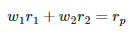

We do this by creating portfolios with stocks that are not correlated. We want to calculate expected returns by analyzing the returns of each stock multiplied by its weight.

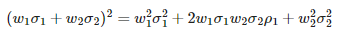

The standard deviation of the portfolio is found this way. Sum multiple calculations starting by finding the product of the first securities weight squared times its standard deviation squared. The middle is 2 times the correlation coefficient between the stocks. And, finally add those to the weight squared times the standard deviation squared for the second security.

**Plotting an Efficient Frontier**

**Stock Portfolio**


In [ ]:
# 1ST LIST port_list = ['CALX', 'NOVT', 'BLDR', 'DXCM', 'RGEN', 'PFE', 'LLY',
# 'AMD', 'NVDA', 'NFLX', 'DAR', 'COST', 'BJ', 'WMT', 'BOOT', 'WING',
# 'LULU', 'NEE', 'AWK', 'MSCI', 'KKR', 'LPX', 'SHW', 'NXRT', 'NSA',
# 'CBRE', 'AES']

# 2ND LIST port_list = ['CALX', 'NOVT', 'RGEN', 'LLY',
# 'AMD', 'NFLX', 'COST', 'BJ', 'WING',
# 'LULU', 'NEE', 'MSCI', 'KKR', 'SHW', 'NSA',
# 'CBRE']
port_list = ['CALX', 'NOVT', 'RGEN', 'LLY',
'AMD', 'NFLX', 'COST', 'BJ', 'WING',
'MSCI', 'CBRE']
num_stocks = len(port_list)
num_stocks

Merge All Data by Closing Price


In [ ]:
mult_df = merge_df_by_column_name('Close',  S_DATE, 
                                  E_DATE, *port_list)
mult_df

Plot Price of Investments over Total Dataset


In [ ]:
# Plot out prices for each stock since beginning of 2017
fig = px.line(mult_df, x=mult_df.index, y=mult_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=1200, width=1800, 
                  showlegend=True)
fig.show()

Cumulative Return for all Stocks


In [ ]:
mult_cum_df = merge_df_by_column_name('cum_return',  S_DATE, 
                                  E_DATE, *port_list)
mult_cum_df

In [ ]:
# Plot out cumulative returns for each stock since beginning of 2017
fig = px.line(mult_cum_df, x=mult_cum_df.index, y=mult_cum_df.columns)
fig.update_xaxes(title="Date", rangeslider_visible=True)
fig.update_yaxes(title="Price")
fig.update_layout(height=1200, width=1800, 
                  showlegend=True)
fig.show()

Mean Returns


In [ ]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean() * 252 # 252 average trading days per year
mean_ret

Correlation


In [ ]:
# We want great performing stocks that go up when others go down to smooth the returns over the year
returns.corr()

Generate Random Weights Equal to 1


In [ ]:
# Generate 11 random values that sum to 1
weights = np.random.random(num_stocks)
weights /= np.sum(weights)
print('Weights :', weights)
print('Total Weight :', np.sum(weights))

Calculating Return of Portfolio using a Random Weighting


In [ ]:
# Provide return of portfolio using random weights over the whole dataset
np.sum(weights * returns.mean()) * 252

Calculating Volatility


In [ ]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))


Analyzing Returns & Risks of 10000 Combinations


In [ ]:
p_ret = [] # Returns list
p_vol = [] # Volatility list
p_SR = [] # Sharpe Ratio list
p_wt = [] # Stock weights list


for x in range(10000):
    # Generate random weights
    p_weights = np.random.random(num_stocks)
    p_weights /= np.sum(p_weights)
    
    # Add return using those weights to list
    ret_1 = np.sum(p_weights * returns.mean()) * 252
    p_ret.append(ret_1)
    
    # Add volatility or standard deviation to list
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)
    
    # Get Sharpe ratio
    SR_1 = (ret_1 - risk_free_rate) / vol_1
    p_SR.append(SR_1)
    
    # Store the weights for each portfolio
    p_wt.append(p_weights)
    
# Convert to Numpy arrays
p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt

Plotting the Efficient Frontier


In [ ]:
# Create a dataframe with returns and volatility
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})

ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(16, 9))

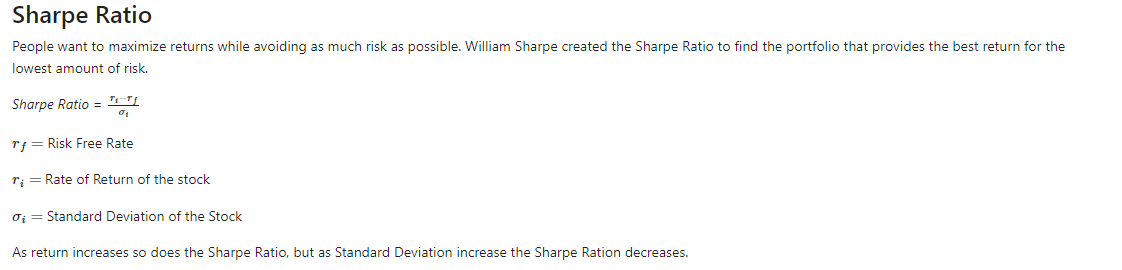

In [ ]:
# Return the index of the largest Sharpe Ratio
SR_idx = np.argmax(p_SR)

# Find the ideal portfolio weighting at that index
i = 0
while i < num_stocks:
    print("Stock : %s : %2.2f" % (port_list[i], (p_wt[SR_idx][i] * 100)))
    i += 1
    
# Find volatility of that portfolio
print("\nVolatility :", p_vol[SR_idx])
      
# Find return of that portfolio
print("Return :", p_ret[SR_idx])

Find percentage closest to 1 and use it as the basis for calculating all other shares Since CBRE is .6 : CALX is 7.25 : Multiply cost of CBRE (105.64) by 7 and then divide that by the cost of CALX to get the shares to buy for GNRC

105.64 7 = 739.48 / 64.28 = 25.49 (11 Shares) 64.28 = 707.08

In situations in which prices don't work either discard stock or force 1 share

In [ ]:
def get_port_shares(one_price, force_one, wts, prices):
    # Gets number of stocks to analyze
    num_stocks = len(wts)
    
    # Holds the number of shares for each
    shares = []
    
    # Holds Cost of shares for each
    cost_shares = []
    
    i = 0
    while i < num_stocks:
        # Get max amount to spend on stock 
        max_price = one_price * wts[i]
        
        # Gets number of shares to buy and adds them to list
        num_shares = int(max_price / prices[i])
        
        # If the user wants to force buying one share do it
        if(force_one & (num_shares == 0)):
            num_shares = 1
        
        shares.append(num_shares)
        
        # Gets cost of those shares and appends to list
        cost = num_shares * prices[i]
        cost_shares.append(cost)
        i += 1
        
    return shares, cost_shares

Get Portfolio Weighting


In [ ]:
def get_port_weighting(share_cost):
    
    # Holds weights for stocks
    stock_wts = []
    # All values summed
    tot_val = sum(share_cost)
    print("Total Investment :", tot_val)
    
    for x in share_cost:
        stock_wts.append(x / tot_val)
    return stock_wts

Returns the Value of Portfolio by Date


In [ ]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, 
                                  date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    return port_prices

Approximate Portfolio Weighting Based on Request


In [ ]:
port_list = ["CALX", "NOVT", "RGEN", "LLY", "AMD", "NFLX",
"COST", "BJ", "WING", "MSCI", "CBRE"]

port_wts = [7, 8, 15, 14, 3, 3, 17, 6, 11, 14, 1]

# Get all stock prices on the starting date
port_df_start = merge_df_by_column_name('Close',  '2022-01-07', 
                                  '2022-01-07', *port_list)
# Convert from dataframe to Python list
port_prices = port_df_start.values.tolist()

# Trick that converts a list of lists into a single list
port_prices = sum(port_prices, [])

tot_shares, share_cost = get_port_shares(105.64, True, port_wts, port_prices)
print("Shares :", tot_shares)
print("Share Cost :", share_cost)

# Get list of weights for stocks
stock_wts = get_port_weighting(share_cost)
print("Stock Weights :", stock_wts)

# Get value at end of year
get_port_val_by_date(E_DATE, tot_shares, port_list)